1. Using Reddit's API, you'll collect posts from two subreddits of your choosing.

2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

### Problem Statement


Is it clear what the goal of the project is? To create a model that can predict whether a post is from the nosleep subreddit or from the unresolved mysteries.

What type of model will be developed? -bayes classifier, and a logistic regression

How will success be evaluated? - How well my model can predict if new posts belong to r/unresolvedmysteries subreddit, or if they belond in r/nosleep.



Is it clear who cares about this or why this is important to investigate? I would like it to be used to tell if a story is comepletely fiction, or if a story is based on facts.

Does the student consider the audience and the primary and secondary stakeholders? 

In [135]:
import requests, json, time, re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns 
import wordcloud
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
#imports

In [5]:
def sub_query(subreddit, pages=40):

#set initial conditions
    posts = []
    url = f'https://www.reddit.com/r/{subreddit}/top.json?t=all'
    after = None

#build the loop and print URL
    for _ in range(pages):
        if after == None:
            current_url = url
        else:
            current_url = url + '&after=' + after

        print(current_url)

#make the requests and handle status code. Add time.sleep now (2.b)
        res = requests.get(current_url, headers={'User-agent': 'Foo Bar 1.0'})

        if res.status_code != 200:
            print('Status error', res.status_code)
            break

# Actually deal with the data   
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)

        after = current_dict['data']['after']

#Step 2b:
        time.sleep(.2)
    return posts


In [6]:
nosleep_posts = sub_query('nosleep')

https://www.reddit.com/r/nosleep/top.json?t=all
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_8oueb7
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_7uyiss
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_cd6ktm
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_b5tyjo
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_5iirna
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_5uwi42
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_d453sp
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_27el9i
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_85gn1r
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_9azn5f
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_b8y3xj
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_7x1p9x
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_8dwy2t
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3_9w0asc
https://www.reddit.com/r/nosleep/top.json?t=all&after=t3

In [7]:
unresolved_posts = sub_query('UnresolvedMysteries')

https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_cg9h4x
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_6ni625
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_9rmaf9
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_cb60fb
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_ai3qwl
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_7nm77r
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_ac769y
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_axppaa
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_9z59f6
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_at7zzb
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_6o94bx
https://www.reddit.com/r/UnresolvedMysteries/top.json?t=all&after=t3_cbhexl
https://www.reddit.com/r/Unr

In [8]:
def combine_text(posts):
    return[' '.join([post['title'], post['selftext']]) for post in posts] 

In [9]:
nosleep_text = combine_text(nosleep_posts)

In [10]:
unresolved_text = combine_text(unresolved_posts)

In [11]:
nosleep_df = pd.DataFrame(nosleep_text, columns=['text'])
nosleep_df['nosleep'] = 1

In [12]:
nosleep_df.head()

,text,nosleep
0,She Sold Happiness in Glass Jars The poster re...,1
1,A Shattered Life I don't know when you're goin...,1
2,My sugar daddy asks me for weird favors His Ti...,1
3,Something happened 63 years ago that's haunted...,1
4,My job is watching a woman trapped in a room. ...,1


In [13]:
unresolved_df = pd.DataFrame(unresolved_text, columns=['text'])
unresolved_df['nosleep'] = 0

In [14]:
unresolved_df.head()

,text,nosleep
0,East Area Rapist/Original Night Stalker OFFICI...,0
1,Which mystery industry is the largest buyer of...,0
2,Netflix is reviving UNSOLVED MYSTERIES,0
3,"Mariah Martinez, a 9yo who went missing from L...",0
4,Why does High School Musical's Corbin Bleu hav...,0


In [15]:
reddit = pd.concat([nosleep_df, unresolved_df], ignore_index=True)

In [16]:
reddit.head()

,text,nosleep
0,She Sold Happiness in Glass Jars The poster re...,1
1,A Shattered Life I don't know when you're goin...,1
2,My sugar daddy asks me for weird favors His Ti...,1
3,Something happened 63 years ago that's haunted...,1
4,My job is watching a woman trapped in a room. ...,1


In [17]:
reddit.shape

(1996, 2)

In [18]:
reddit = reddit.drop_duplicates()

In [19]:
reddit['nosleep'].value_counts()

1    999
0    997
Name: nosleep, dtype: int64

In [20]:
reddit['text'] = reddit.text.map(lambda x: re.sub('\s[\/]?r\/[^s]+', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x))
reddit['text'] = reddit.text.map(lambda x: re.sub('(nosleep|unresolvedmysteries)[s]?', ' ', x, flags=re.I))
####Im not really sure how these work, I did a lot of research trying to clean up certain characters in my data.

In [21]:
reddit

,text,nosleep
0,She Sold Happiness in Glass Jars The poster re...,1
1,A Shattered Life I don't know when you're goin...,1
2,My sugar daddy asks me for weird favors His Ti...,1
3,Something happened 63 years ago that's haunted...,1
4,My job is watching a woman trapped in a room. ...,1
...,...,...
1991,Stéphane Parent has been arrested in connectio...,0
1992,"(Solved) Rachel N. Owens Found Alive, Voluntar...",0
1993,Disappeared season 5 updated list Disappeared ...,0
1994,What are the things you immediately write-off ...,0


In [22]:
reddit.to_csv('nosleep.csv', index=False)

In [74]:
X = reddit.drop('nosleep', 1)
y = reddit['nosleep']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=66)


tfidf = TfidfVectorizer(stop_words='english', max_df= .95, min_df=5, )

train_raw = tfidf.fit_transform(X_train['text'])

create a corpus out of the list of titles fit and transform the vectorizer to the corpus.

In [31]:
print(train_raw)

  (0, 7122)	0.01297908895763122
  (0, 1467)	0.01690254935452068
  (0, 7398)	0.012799860510626532
  (0, 5046)	0.02052560471921718
  (0, 6981)	0.015289700001261992
  (0, 9009)	0.02101645804676114
  (0, 4012)	0.011841460628812372
  (0, 4333)	0.014615415620184246
  (0, 6071)	0.018807393096075768
  (0, 6508)	0.018488589077060056
  (0, 2871)	0.012699684159973584
  (0, 7671)	0.026504506983267503
  (0, 12003)	0.01617267090249092
  (0, 4561)	0.037420099219318936
  (0, 8658)	0.02733142340972744
  (0, 7810)	0.023280697924130532
  (0, 6279)	0.023414979108702917
  (0, 804)	0.029953732060924988
  (0, 7642)	0.014803307043951419
  (0, 5435)	0.014996964507340614
  (0, 10772)	0.03413976699628279
  (0, 1159)	0.013478828363222011
  (0, 1525)	0.01759170363791926
  (0, 5906)	0.024606454260007637
  (0, 1318)	0.02893148230482961
  :	:
  (1396, 11770)	0.011135633664374343
  (1396, 4141)	0.040827693077151644
  (1396, 9386)	0.02236842432321561
  (1396, 11185)	0.012680243650765912
  (1396, 3350)	0.014389265846812

convert vectoried data into df

In [32]:
train_df = pd.SparseDataFrame(train_raw, columns=tfidf.get_feature_names())

train_df.head()

,00,000,00am,00pm,01,02,03,04,05,06,...,zealand,zero,zip,zipped,zodiac,zombie,zone,zoning,zoo,zoomed
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.053444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
train_df.dtypes

00        Sparse[float64, nan]
000       Sparse[float64, nan]
00am      Sparse[float64, nan]
00pm      Sparse[float64, nan]
01        Sparse[float64, nan]
                  ...         
zombie    Sparse[float64, nan]
zone      Sparse[float64, nan]
zoning    Sparse[float64, nan]
zoo       Sparse[float64, nan]
zoomed    Sparse[float64, nan]
Length: 12143, dtype: object

filling na with 0

In [34]:
train_df.fillna(0, inplace=True)
train_df.isnull().sum()

00        0
000       0
00am      0
00pm      0
01        0
         ..
zombie    0
zone      0
zoning    0
zoo       0
zoomed    0
Length: 12143, dtype: int64

In [35]:
train_df.head()

,00,000,00am,00pm,01,02,03,04,05,06,...,zealand,zero,zip,zipped,zodiac,zombie,zone,zoning,zoo,zoomed
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.053444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_test.head()

,text
753,"I used to hack baby monitors. One night, I lea..."
1399,"Doug Cleaves, a single father and double amput..."
921,Do you know how many people went missing in th...
1052,"In the spirit of Halloween, what are some of t..."
162,"I used FaceApp, which shows what you'll look l..."


In [37]:
#transforming and filling nulls with 0
test_raw = tfidf.transform(X_test['text'])
test_df = pd.SparseDataFrame(test_raw,columns=tfidf.get_feature_names())
test_df.fillna(0, inplace=True)
test_df.head()

,00,000,00am,00pm,01,02,03,04,05,06,...,zealand,zero,zip,zipped,zodiac,zombie,zone,zoning,zoo,zoomed
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.032573,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.013955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.011087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.168999,0.0,0.0,0.0,0.0


fit model using no sleep as the target

Gridsearching over randomforest classifier fitting and scoring

In [38]:
params = { 
    'min_samples_split' : [12, 25, 40],  
}

rf = RandomForestClassifier(n_estimators=100)

gs = GridSearchCV(rf, param_grid=params, return_train_score=True, cv=5)

gs.fit(train_df, y_train)
gs.score(train_df,y_train)

In [42]:
gs.score(test_df,y_test)

0.9699499165275459

In [43]:
gs.best_params_

{'min_samples_split': 12}

In [44]:
gs.best_estimator_.feature_importances_

array([7.14747733e-05, 1.78328951e-04, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [45]:
feat_importance = pd.DataFrame(gs.best_estimator_.feature_importances_, train_df.columns, columns=['importance'])

feat_importance


In [136]:
plt.figure(figsize=(16,9))
temp = feat_importance.sort_values('importance', ascending=False).head(20)
plt.barh(temp.index,temp['importance'])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Amount of information gained')
plt.ylabel('Feature', fontsize=20);

KeyError: 'importance'

<Figure size 1152x648 with 0 Axes>

In [48]:
y_test.value_counts(normalize=True)

1    0.500835
0    0.499165
Name: nosleep, dtype: float64

# ***** Best Model ***** 


In [49]:
from sklearn.pipeline import Pipeline


# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=66)

# We need to calculate baseline accuracy in order to tell if our model is outperforming the null model (predicting the majority class).

y_test.value_counts(normalize=True)

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe_params = {
    'cvec__max_features' : [2500, 3000, 3500], 
    'cvec__ngram_range': [(1,1), (1,2)]
}

#instantiate gridsearch
gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=3) # 3-fold cross-validation.





# Fit GridSearch to training data.
gs.fit(X_train['text'],y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [50]:
gs.best_params_

{'cvec__max_features': 2500, 'cvec__ngram_range': (1, 2)}

In [51]:
# What's the best score?
print(gs.best_score_)

0.9820493642483171


In [52]:
# Save best model as gs_model.

gs_model = gs.best_estimator_


# Score model on training set.
gs_model.score(X_train['text'], y_train)


In [138]:
gs_model.score(X_train['text'],y_train)

1.0

In [54]:
# Score model on testing set.
gs_model.score(X_test['text'], y_test)

0.9817905918057663

In [77]:
best_cv = CountVectorizer(max_features= 2500, ngram_range=(1, 2))

In [80]:
train_raw = best_cv.fit_transform(X_train['text'])
train_df = pd.SparseDataFrame(train_raw, columns=best_cv.get_feature_names())
train_df.fillna(0,inplace=True)
train_df.isnull().sum().sum()

0

In [81]:
train_df.head()

,00,000,10,100,11,12,13,14,15,16,...,you the,you think,you to,you ve,you want,you were,you will,young,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [84]:
gs_model

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=2500, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                           

In [85]:
lr = LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False)

In [90]:
lr.fit(train_df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
feat_importance = pd.DataFrame(np.transpose(lr.coef_), train_df.columns, columns=['nosleep'])

In [108]:
unresolved_importance = feat_importance.sort_values(by='nosleep').head(20) #feature importance by percentage

In [109]:
nosleep_importance = feat_importance.sort_values(by='nosleep', ascending=False).head(20) #48%

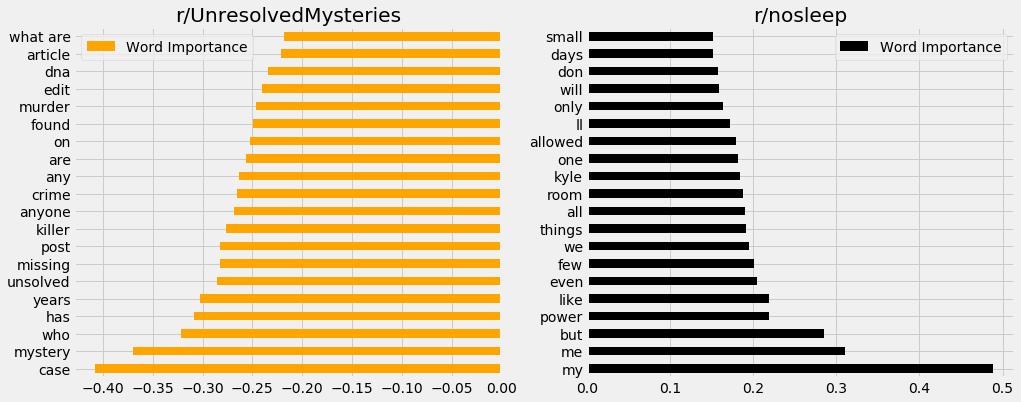

In [137]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))


unresolved_importance.plot.barh(ax=ax1, title='r/UnresolvedMysteries', color='orange')

nosleep_importance.plot.barh(ax=ax2, title='r/nosleep', color='black');
ax1.legend(['Word Importance'])
ax2.legend(['Word Importance'])

In [100]:
from sklearn.metrics import confusion_matrix

In [101]:
preds = gs_model.predict(X_test['text'])

confusion_matrix(y_test, preds)

array([[296,   3],
       [  9, 291]])

In [102]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [69]:
tn
#actual unresolved predicted unresolved

326

In [70]:
fp
#actual unresolved predicted no sleep

3

In [71]:
fn
#actual nosleep preidcted unresolved

9

In [72]:
tp
#Actual nosleep predicted no sleep

321

In [59]:
data = [y_test, preds]

new_df = pd.DataFrame(y_test)
new_df['predictions'] = preds


In [62]:
new_df['diff'] = new_df.apply(lambda x: 0 if x['predictions'] == x['nosleep'] else 1, axis=1)

In [63]:
new_df.sort_values(by='diff',ascending=False).head(20)

,nosleep,predictions,diff
699,1,0,1
1084,0,1,1
703,1,0,1
170,1,0,1
620,1,0,1
1345,0,1,1
958,1,0,1
229,1,0,1
1150,0,1,1
906,1,0,1


In [64]:
X.iloc[472].text

"My sister dropped off my niece last night. I don't think she's coming back.  To clarify, I haven’t seen my younger sister Mara in a little over five years. She was a little over eighteen years old, a few months pregnant, and was determined to keep her baby. I told her exactly what I thought- I thought she was a goddamn idiot and that she either needed to give it up for adoption or I’d drive her to the abortion clinic myself.\n\nWe had a screaming fight before she stormed out, saying she was going to stay with her baby’s daddy and that they’d be a happy family together.\n\nLike I said, it’s been five years. Five years and a lot changed. I tried contacting her probably a dozen times, but when she sent me a picture flipping up her middle finger, I got the message. I gave up. If she wanted to live like that, fine by me. She ended up blocking me on Facebook, she cut off both our parents, and I figured I’d never see her again. \xa0\n\nWhen I heard the doorbell I thought that one of my frien

In [65]:
X.iloc[170].text

"I don't think the new mods are working out Removed story\n\nexpand all collapse all\n\n**[–] subreddit message via sleep [M] sent 1 hour ago**  \n\nYour post has been removed from sleep. Stories must be believable within reason. This means that the narrator must be physically and mentally capable of posting, and that the events of the story cannot be proven to be false on a large scale.\n\n**[–] to sleep [M] sent 1 hour ago** \n\nHi – thanks for the information. Can you explain to me how my story is rule-breaking? The narrator lives, is capable of posting despite the described trauma, and it cannot be disproved by looking outside or reading a newspaper. What element needs to be changed? I’m eager to get it re-approved as soon as possible. Thank you for your assistance in this issue.\n\n**[–] subreddit message via sleep [M] sent 1 hour ago** \n\nThe story lacks believability because you claim that the intruder climbs through a window on the second floor. This contradicts the fact that 

In [66]:
X.iloc[1345].text

"Are you part of some person's Unresolved Mystery? When I was a senior in high school (Rochester, New York) I skipped school to visit my girlfriend who was home sick.  As this was a high school romance and we were home alone things got naked.\n\nHer mom came home, I jumped out the window and started to run the half a mile home... completely naked.  (Mostly through a wooded park but also some back yards)\n\nHalfway home, in a wooded backyard I came across a snowmobile with a big red cover (it was late spring at the time).  I wrapped the cover around myself and started to walk the rest of the way home when the owner of the snowmobile walked out of his house and yelled at me to stop.\n\nI ran as fast as I could, through a few more backyards and made it home without anyone else seeing me.  \n\nThis guy went door to door looking for the naked kid who stole his snow mobile cover.  My parents talked to him that night as he went up and down all the adjacent blocks looking for answers.  He stop

In [67]:
X.iloc[1150].text

'Brandon Lawson 911 Trancription- I spent 10 hours picking the 911 call apart. He doesn\'t say "staper" and he wasn\'t alone. Update:  As promised, here\'s some of the edited audio files!  Thanks for all the positive feedback, this took a ton of work, and now I feel it was definitely worth it!\n\n \n\n\nThis is my first write up.  I\'ve been meaning to listen to the Brandon Lawson 911 audio for a while, and I just happened to be recovering from a minor surgery this week, so I dove into the rabbit hole.  I have a background in audio recording and have some pretty great software, speakers, and headphones to listen with, and I\'ve spent over 10 hours listening to every syllable and word in this 38 second phone call.  I believe I have it as accurately transcribed as possible.  \n\nI am also 99% certain this is not the entire phone call.  I\'ll write the entire transcription, and then I\'ll break down each piece.\n\nOperator: 911 Emergency...\n\nBrandon: Yes, I\'m in the middle of the field